# BQML - ARIMA+ Multivariate

In [5]:
GCP_PROJECTS = !gcloud config get-value project
PROJECT_ID = GCP_PROJECTS[0]
PROJECT_NUM = !gcloud projects list --filter="$PROJECT_ID" --format="value(PROJECT_NUMBER)"
PROJECT_NUM = PROJECT_NUM[0]
LOCATION = 'us-central1'
REGION = "us-central1"

# VERTEX_SA = '934903580331-compute@developer.gserviceaccount.com'
VERTEX_SA = 'jt-vertex-sa@hybrid-vertex.iam.gserviceaccount.com'

print(f"PROJECT_ID: {PROJECT_ID}")
print(f"PROJECT_NUM: {PROJECT_NUM}")
print(f"LOCATION: {LOCATION}")
print(f"REGION: {REGION}")
print(f"VERTEX_SA: {VERTEX_SA}")

PROJECT_ID: hybrid-vertex
PROJECT_NUM: 934903580331
LOCATION: us-central1
REGION: us-central1
VERTEX_SA: jt-vertex-sa@hybrid-vertex.iam.gserviceaccount.com


In [2]:
VERSION='jtv4'

In [8]:
REGION = 'us-central1'
EXPERIMENT = 'forecasting-2'
SERIES = f'{VERSION}-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = 'forecasting-1'

viz_limit = 12

EXPERIMENT_NAME = f"nyc_{BQ_DATASET}"
print(f'EXPERIMENT_NAME: {EXPERIMENT_NAME}')

EXPERIMENT_NAME: nyc_jtv2_forecasting


In [9]:
from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

from google.cloud import aiplatform as vertex_ai

In [10]:
bq = bigquery.Client(project=PROJECT_ID)

vertex_ai.init(
    project=PROJECT_ID, 
    location=REGION,
    # credentials=credentials
)

In [11]:
# ds = bigquery.Dataset(f"{PROJECT_ID}.{BQ_DATASET}")
# ds.location = 'us' #REGION
# ds.labels = {'notebook': f"{EXPERIMENT}"}
# ds = bq.create_dataset(dataset = ds, exists_ok = True)

In [12]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
COVARIATE_COLUMNS = ['avg_tripduration', 'pct_subscriber', 'ratio_gender', 'capacity'] # could be empty

VERTEX_AI_MODEL_ID='v1_arimaplusxreg'
MODEL_VERSION='v1'
XAI_FLAG="TRUE"

## review BQ source

In [13]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            GROUP BY splits
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE splits ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE splits = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE splits = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


In [14]:
query = f"""
    SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}, splits,
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()

In [15]:
# CUSTOMIZE
forecast_granularity = 'DAY'
forecast_horizon = 14
forecast_test_length = 14
#forecast_val_length = 14

VERTEX_AI_MODEL_ID='v1_arimaplusxreg'
MODEL_VERSION='v1'
XAI_FLAG="TRUE"

In [16]:
query = f"""
    CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg_{MODEL_VERSION}`
    OPTIONS
      (model_type = 'ARIMA_PLUS_XREG',
       time_series_timestamp_col = '{TIME_COLUMN}',
       time_series_data_col = '{TARGET_COLUMN}',
       auto_arima_max_order = 5,
       holiday_region = 'US',
       horizon = {forecast_horizon}+{forecast_test_length},
       -- Vertex AI fields
       model_registry="vertex_ai", 
       vertex_ai_model_id='{VERTEX_AI_MODEL_ID}',
       vertex_ai_model_version_aliases=['{MODEL_VERSION}', 'experimental']
       -- enable_global_explain={XAI_FLAG}
      ) AS
    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
    WHERE splits in ('TRAIN','VALIDATE')
        AND {SERIES_COLUMN} = 'Central Park S & 6 Ave'
"""
print(query)


    CREATE OR REPLACE MODEL `hybrid-vertex.jtv2_forecasting.forecasting-1_arimaplusxreg_v1`
    OPTIONS
      (model_type = 'ARIMA_PLUS_XREG',
       time_series_timestamp_col = 'starttime',
       time_series_data_col = 'num_trips',
       auto_arima_max_order = 5,
       holiday_region = 'US',
       horizon = 14+14,
       -- Vertex AI fields
       model_registry="vertex_ai", 
       vertex_ai_model_id='v1_arimaplusxreg',
       vertex_ai_model_version_aliases=['v1', 'experimental']
       -- enable_global_explain=TRUE
      ) AS
    SELECT starttime, num_trips,
        avg_tripduration, pct_subscriber, ratio_gender, capacity
    FROM `hybrid-vertex.jtv2_forecasting.forecasting-1_prepped`
    WHERE splits in ('TRAIN','VALIDATE')
        AND start_station_name = 'Central Park S & 6 Ave'



In [17]:
job = bq.query(query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 14.051


## Review The ARIMA Coefficients
* Reference for `ML.ARIMA_COEFFICIENTS`

In [18]:
query = f"""
    SELECT *
    FROM ML.ARIMA_COEFFICIENTS(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg_{MODEL_VERSION}`)
"""
coefficients = bq.query(query).to_dataframe()
coefficients

,ar_coefficients,ma_coefficients,intercept_or_drift,processed_input,weight,category_weights
0,[],"[-0.8285041180283981, -0.212754768882295, 0.61...",0.0,None,NaN,[]
1,[],[],NaN,avg_tripduration,-0.001514,[]
2,[],[],NaN,pct_subscriber,-302.167414,[]
3,[],[],NaN,ratio_gender,2.385852,[]
4,[],[],NaN,capacity,2.569851,[]
5,[],[],NaN,__INTERCEPT__,-66.170817,[]


## Review the input features
* Reference for `ML.FEATURE_INFO`

In [19]:
query = f"""
    SELECT *
    FROM ML.FEATURE_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg_{MODEL_VERSION}`)
"""
featureInfo = bq.query(query).to_dataframe()
featureInfo.head()

,input,min,max,mean,median,stddev,category_count,null_count,dimension
0,num_trips,1.000,555.000000,144.153912,130.000000,112.409702,<NA>,0,<NA>
1,starttime,NaN,NaN,NaN,NaN,NaN,1163,0,<NA>
2,avg_tripduration,336.625,34597.615385,1918.560216,1835.012000,1334.905339,<NA>,0,<NA>
3,pct_subscriber,0.000,1.000000,0.497785,0.465116,0.214707,<NA>,0,<NA>
4,ratio_gender,0.000,14.000000,0.908012,0.566667,1.329083,<NA>,26,<NA>


## Review the Training Information
* Reference for `ML.TRAINING_INFO`

In [20]:
query = f"""
    SELECT *
    FROM ML.TRAINING_INFO(MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg_{MODEL_VERSION}`)
"""
trainingInfo = bq.query(query).to_dataframe()
trainingInfo.head()

,training_run,iteration,duration_ms
0,0,0,6550


# Forecast Evaluation

## Forecast Metrics

In [21]:
query = f"""
    SELECT *
    FROM ML.EVALUATE(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg_{MODEL_VERSION}`,
        (
            SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            WHERE splits = 'TEST'
                AND {SERIES_COLUMN} = 'Central Park S & 6 Ave'
        ),
        STRUCT(TRUE AS perform_aggregation))
"""
metrics = bq.query(query).to_dataframe()
metrics

,mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error,symmetric_mean_absolute_percentage_error
0,84.689505,12568.568433,112.109627,37.609473,31.090428


## Evaluate Time Series Models

* Reference for `ML.ARIMA_EVALUATE`

A model metrics table: ARIMA terms:

* p = how many autoregressive terms
* d = how many nonseasonal differences needed for stationarity
* q = number of lagged forecast errors (moving average part)

In [22]:
query = f"""
    SELECT *
    FROM ML.ARIMA_EVALUATE(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg_{MODEL_VERSION}`,
        STRUCT(FALSE as show_all_candidate_models))
"""
arima_metrics = bq.query(query).to_dataframe()
arima_metrics

,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes,error_message
0,0,1,5,False,-5857.89421,11727.788421,1266.716809,"[WEEKLY, YEARLY]",True,True,False,


## Forecast Time Series
* Reference for `ML.FORECAST`

Calculates the forecasted value per timestamp and provides standard error and prediction intervals at the requested confidence level.

The default horizon is 3 so this parameter may need to be set to the size used at training.

> NOTE When using external regressors their values are need for forecast to be computed.

In [23]:
query = f"""
    SELECT *
    FROM ML.FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg_{MODEL_VERSION}`,
        STRUCT({forecast_test_length} AS horizon, 0.95 AS confidence_level),
        (
            SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            WHERE splits = 'TEST'
                AND {SERIES_COLUMN} = 'Central Park S & 6 Ave'
        )
        )
"""
forecast = bq.query(query).to_dataframe()
forecast

,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound
0,2016-09-17 00:00:00+00:00,373.586447,35.590965,0.95,303.954215,443.218679
1,2016-09-18 00:00:00+00:00,461.201370,36.110553,0.95,390.552587,531.850153
2,2016-09-19 00:00:00+00:00,336.684709,36.140398,0.95,265.977536,407.391882
3,2016-09-20 00:00:00+00:00,238.410865,41.585964,0.95,157.049670,319.772061
4,2016-09-21 00:00:00+00:00,227.453173,48.100267,0.95,133.347016,321.559331
5,2016-09-22 00:00:00+00:00,208.416624,48.156597,0.95,114.200260,302.632987
6,2016-09-23 00:00:00+00:00,271.401496,48.212861,0.95,177.075055,365.727938
7,2016-09-24 00:00:00+00:00,379.234904,48.269059,0.95,284.798513,473.671294
8,2016-09-25 00:00:00+00:00,366.943850,48.325191,0.95,272.397638,461.490062
9,2016-09-26 00:00:00+00:00,257.832584,48.381259,0.95,163.176678,352.488490


## Forecast + Explanations for Time Series
* Reference for `ML.EXPLAIN_FORECAST`

> NOTE At this point in time (March 2023) the ARIMA_PLUS_XREG is in preview and does not yet use the ML.EXPLAIN_FORECAST function. In preparation for it the results of the forecast table above are used and remapped to the expected column names.

In [24]:
query = f"""
    SELECT *,
        'Central Park S & 6 Ave' AS {SERIES_COLUMN},
        EXTRACT(DATE FROM forecast_timestamp) AS {TIME_COLUMN},
        forecast_value AS time_series_adjusted_data
    FROM ML.FORECAST(
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg_{MODEL_VERSION}`,
        STRUCT({forecast_test_length} AS horizon, 0.95 AS confidence_level),
        (
            SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                {', '.join(COVARIATE_COLUMNS)}
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            WHERE {SERIES_COLUMN} = 'Central Park S & 6 Ave'
        )
        )
    ORDER BY {SERIES_COLUMN}, {TIME_COLUMN}
"""
explain = bq.query(query).to_dataframe()
explain

,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,start_station_name,starttime,time_series_adjusted_data
0,2016-09-17 00:00:00+00:00,373.586447,35.590965,0.95,303.954215,443.218679,Central Park S & 6 Ave,2016-09-17,373.586447
1,2016-09-18 00:00:00+00:00,461.201370,36.110553,0.95,390.552587,531.850153,Central Park S & 6 Ave,2016-09-18,461.201370
2,2016-09-19 00:00:00+00:00,336.684709,36.140398,0.95,265.977536,407.391882,Central Park S & 6 Ave,2016-09-19,336.684709
3,2016-09-20 00:00:00+00:00,238.410865,41.585964,0.95,157.049670,319.772061,Central Park S & 6 Ave,2016-09-20,238.410865
4,2016-09-21 00:00:00+00:00,227.453173,48.100267,0.95,133.347016,321.559331,Central Park S & 6 Ave,2016-09-21,227.453173
5,2016-09-22 00:00:00+00:00,208.416624,48.156597,0.95,114.200260,302.632987,Central Park S & 6 Ave,2016-09-22,208.416624
6,2016-09-23 00:00:00+00:00,271.401496,48.212861,0.95,177.075055,365.727938,Central Park S & 6 Ave,2016-09-23,271.401496
7,2016-09-24 00:00:00+00:00,379.234904,48.269059,0.95,284.798513,473.671294,Central Park S & 6 Ave,2016-09-24,379.234904
8,2016-09-25 00:00:00+00:00,366.943850,48.325191,0.95,272.397638,461.490062,Central Park S & 6 Ave,2016-09-25,366.943850
9,2016-09-26 00:00:00+00:00,257.832584,48.381259,0.95,163.176678,352.488490,Central Park S & 6 Ave,2016-09-26,257.832584


## Visualize Time Series with Forecast

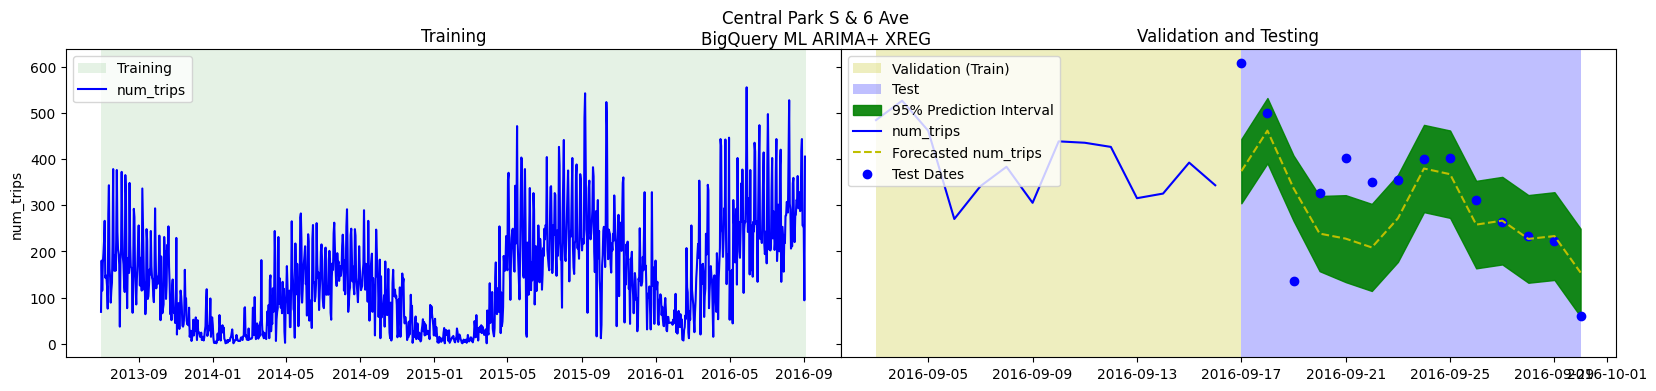

In [25]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
series = ['Central Park S & 6 Ave']
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]
        #fit_traindf = explain[(explain[SERIES_COLUMN] == st) & (explain[TIME_COLUMN] < keyDates['val_start'][0])]
        #fit_valdf = explain[(explain[SERIES_COLUMN] == st) & (explain[TIME_COLUMN] >= keyDates['val_start'][0]) & (explain[TIME_COLUMN] < keyDates['test_start'][0])]
        fit_testdf = explain[(explain[SERIES_COLUMN] == st) & (explain[TIME_COLUMN] >= keyDates['test_start'][0])]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
        axes[1].fill_between(fit_testdf[TIME_COLUMN], fit_testdf['prediction_interval_lower_bound'], fit_testdf['prediction_interval_upper_bound'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        #axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        #axes[0].plot(fit_traindf[TIME_COLUMN], fit_traindf['time_series_adjusted_data'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        #axes[1].plot(fit_valdf[TIME_COLUMN], fit_valdf['time_series_adjusted_data'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_testdf[TIME_COLUMN], fit_testdf['time_series_adjusted_data'], color = 'y', label = f'Forecasted {TARGET_COLUMN}', linestyle='dashed')

        axes[1].scatter(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b', label = 'Test Dates')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st + f"\nBigQuery ML ARIMA+ XREG")

        # display result
        plt.show()

## Using SQL to Calculate Metrics

* see calculations [here](https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20Forecasting/BQML%20Multivariate%20Forecasting%20with%20ARIMA%2B%20XREG.ipynb)

In [26]:
query = f"""
    WITH    
        FORECAST AS (
            SELECT
                'Central Park S & 6 Ave' AS {SERIES_COLUMN},
                EXTRACT(DATE FROM forecast_timestamp) AS {TIME_COLUMN},
                forecast_value,
                'forecast' as time_series_type
            FROM ML.FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg_{MODEL_VERSION}`,
                STRUCT({forecast_test_length} AS horizon, 0.95 AS confidence_level),
                (
                    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                        {', '.join(COVARIATE_COLUMNS)}
                    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
                    WHERE splits = 'TEST'
                        AND {SERIES_COLUMN} = 'Central Park S & 6 Ave'
                )   
            )
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            WHERE splits = 'TEST' AND {SERIES_COLUMN} = 'Central Park S & 6 Ave'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        ),
        COMBINED AS (
            SELECT *
            FROM FORECAST
            INNER JOIN ACTUAL
            USING ({SERIES_COLUMN}, {TIME_COLUMN})  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT {SERIES_COLUMN}, time_series_type, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY {SERIES_COLUMN}, time_series_type
    ORDER BY {SERIES_COLUMN}, time_series_type    
"""
customMetrics = bq.query(query = query).to_dataframe()
customMetrics.head(viz_limit)

,start_station_name,time_series_type,MAPE,MAE,pMAE,MSE,RMSE,pRMSE
0,Central Park S & 6 Ave,forecast,0.376095,84.689505,0.259499,12568.568433,112.109627,0.343518


### Overall metrics

In [27]:
query = f"""
    WITH
        FORECAST AS (
            SELECT
                'Central Park S & 6 Ave' AS {SERIES_COLUMN},
                EXTRACT(DATE FROM forecast_timestamp) AS {TIME_COLUMN},
                forecast_value,
                'forecast' as time_series_type
            FROM ML.FORECAST(
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_arimaplusxreg_{MODEL_VERSION}`,
                STRUCT({forecast_test_length} AS horizon, 0.95 AS confidence_level),
                (
                    SELECT {TIME_COLUMN}, {TARGET_COLUMN},
                        {', '.join(COVARIATE_COLUMNS)}
                    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
                    WHERE splits = 'TEST'
                        AND {SERIES_COLUMN} = 'Central Park S & 6 Ave'
                )   
            )
        ),
        ACTUAL AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, sum({TARGET_COLUMN}) as actual_value
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_prepped`
            WHERE splits = 'TEST'
            GROUP BY {SERIES_COLUMN}, {TIME_COLUMN}
        ),
        COMBINED AS (
            SELECT *
            FROM FORECAST
            INNER JOIN ACTUAL
            USING ({SERIES_COLUMN}, {TIME_COLUMN})  
        ),
        DIFFS AS (
            SELECT {SERIES_COLUMN}, {TIME_COLUMN}, 'forecast' as time_series_type, 
                actual_value, forecast_value, (actual_value - forecast_value) as diff
            FROM COMBINED
        )
    SELECT time_series_type, 
        AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
        AVG(ABS(diff)) as MAE,
        SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
        AVG(POW(diff, 2)) as MSE,
        SQRT(AVG(POW(diff, 2))) as RMSE,
        SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY time_series_type
    ORDER BY time_series_type    
"""
customMetricsOverall = bq.query(query).to_dataframe()
customMetricsOverall

,time_series_type,MAPE,MAE,pMAE,MSE,RMSE,pRMSE
0,forecast,0.376095,84.689505,0.259499,12568.568433,112.109627,0.343518


## Log Vertex Experiments

In [28]:
from datetime import datetime

# create run name
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")
EXPERIMENT_RUN_NAME = f"run-{TIMESTAMP}"

# log params and metrics to dicts
params = {}
# params["budget_hrs"] = MILLI_NODE_HRS
params["horizon"] = forecast_horizon
# params["context_window"] = CONTEXT_WINDOW
params["model_type"] = f"arimaplusxreg_{MODEL_VERSION}"

metrics_dict = {}
metrics_dict["MAPE"] = customMetricsOverall['MAPE'][0]
metrics_dict["MAE"] = customMetricsOverall['MAE'][0]
metrics_dict["pMAE"] = customMetricsOverall['pMAE'][0]
metrics_dict["MSE"] = customMetricsOverall['MSE'][0]
metrics_dict["RMSE"] = customMetricsOverall['RMSE'][0]
metrics_dict["pRMSE"] = customMetricsOverall['pRMSE'][0]

# # Create and log experiment
vertex_ai.init(experiment=EXPERIMENT_NAME.replace("_","-"))

with vertex_ai.start_run(EXPERIMENT_RUN_NAME) as my_run:
    my_run.log_metrics(metrics_dict)
    my_run.log_params(params)

    vertex_ai.end_run()

Associating projects/934903580331/locations/us-central1/metadataStores/default/contexts/nyc-jtv2-forecasting-run-20230515113935 to Experiment: nyc-jtv2-forecasting


# Register model in Vertex AI Model Registry

In [30]:
# Initiate Vertex AI Model Registry for `VERTEX_AI_MODEL_ID` model entry
registry = vertex_ai.models.ModelRegistry(VERTEX_AI_MODEL_ID)

In [31]:
# Get model versions
versions = registry.list_versions()

for version in versions:
    version_id = version.version_id
    version_created_time = datetime.fromtimestamp(
        version.version_create_time.timestamp()
    ).strftime("%m/%d/%Y %H:%M:%S")
    version_aliases = version.version_aliases
    print(
        f"Model version {version_id} was created at {version_created_time} with aliases {version_aliases}",
    )

Getting versions for projects/hybrid-vertex/locations/us-central1/models/v1_arimaplusxreg
Model version 1 was created at 05/15/2023 11:36:40 with aliases ['v1', 'experimental', 'default']
